<a href="https://colab.research.google.com/github/lf2foce/quant/blob/master/100beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install plotly==4.12.0
!pip install chart_studio

In [41]:
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-deep")

In [42]:
#vn200
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/McapRank200_25.csv', parse_dates=["Date"]) #nrows=1000
data_index = data_index[ data_index['Date'] > '2020-01-01']
#data_index = data_index[ data_index['Mcap_Rank'] < 101]
data_index.drop(columns=['Mcap_Rank', 'buckets', 'Month', 'Quarter', 'Year'], inplace=True)

sector = pd.read_csv('/content/drive/My Drive/data_analyst/sector.csv')
vn30_ticker = pd.read_csv('/content/drive/My Drive/data_analyst/vn30.csv')
data_index =pd.merge(data_index, sector, on ='Ticker', how ='left' )


data_index.tail()

,Date,Ticker,Adj_Close,MCAP,Liquidity,SectorL2,SectorL1
36395,2020-09-24,FRT,24650.0,1.946901e+12,27512851000,Retail L2,Consumer Services L1
36396,2020-09-24,VSC,34800.0,1.918273e+12,1869804000,Industrial Goods & Services L2,Industrials L1
36397,2020-09-24,DNW,19000.0,1.900000e+12,45600000,Utilities L2,Utilities L1
36398,2020-09-24,KSV,9500.0,1.900000e+12,0,Basic Resources L2,Basic Materials L1
36399,2020-09-24,SGP,8700.0,1.881766e+12,796920000,Industrial Goods & Services L2,Industrials L1


In [43]:
fundamental = data_index.loc[data_index['Date'] == data_index['Date'].max(), ['Ticker', 'Adj_Close', 'MCAP', 'SectorL2']].reset_index(drop=True)
fundamental.head()

,Ticker,Adj_Close,MCAP,SectorL2
0,VCB,86100.0,3.193343e+14,Banks L2
1,VIC,93000.0,3.145660e+14,Real Estate L2
2,VHM,77100.0,2.536215e+14,Real Estate L2
3,VNM,127300.0,2.216774e+14,Food & Beverage L2
4,BID,40900.0,1.645005e+14,Banks L2


In [44]:
data_index_pivot = data_index.pivot(index="Date", columns="Ticker", values="Adj_Close")
data_index_pivot = data_index_pivot.dropna(how="any", axis=1)
data_index_pivot.head()

Ticker,AAA,ACB,ACV,ANV,AST,AVC,BAB,BHN,BIC,BID,BMP,BOT,BSR,BVH,BWE,BWS,CAB,CAV,CHP,CII,CMG,CTD,CTG,DBD,DCM,DHB,DHC,DHG,DIG,DNH,DPM,DRC,DTK,DVN,DXG,E1VFVN30,EIB,FLC,FOX,FPT,...,SQC,SSI,STB,TCB,TCH,TDM,TID,TLG,TMP,TPB,TRA,TVN,VBB,VCB,VCF,VCG,VCI,VCP,VCS,VCW,VEA,VEF,VGC,VGI,VGT,VHC,VHM,VIB,VIC,VJC,VND,VNM,VNR,VPB,VPI,VRE,VSF,VSH,VSN,VTP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,12242.031873,17699.218750,74000.0,21583.908045,83023.255815,25151.999999,16632.432433,76100.0,25500.0,46900.0,42416.077803,55800.0,8200.0,69000.0,22950.0,29125.781777,140900.0,54045.092024,18084.905660,22600.0,35900.0,50807.547169,21500.0,53721.153845,6510.0,7200.0,36785.294118,88175.851976,13800.0,22698.605772,11905.547786,22831.578946,8240.963855,10021.818181,14300.0,14780.0,17700.0,4720.0,37338.921548,48973.381199,...,82000.0,14912.244477,10200.0,23800.0,32417.349397,25636.708860,30200.0,37910.686743,34212.499999,21300.0,57008.310249,6500.0,16000.0,90800.0,178000.0,26500.0,27253.012048,58000.0,69620.893562,31000.0,45500.0,111000.0,17034.146342,25300.0,8100.000000,38900.0,84900.0,17600.0,115000.0,148000.0,13904.716981,116374.115618,19904.761905,20550.0,42200.0,34350.0,8500.0,21600.0,29420.849420,81641.843970
2020-01-03,12194.023905,17699.218750,74200.0,21583.908045,82241.860466,25247.999999,16632.432433,78000.0,25500.0,46700.0,42275.160601,55800.0,8100.0,68600.0,22800.0,30429.921259,140900.0,54045.092024,18084.905660,23100.0,35800.0,51288.679244,21300.0,54011.538461,6410.0,7200.0,36494.117647,87409.105437,13900.0,22698.605772,11767.645688,22357.894736,8240.963855,10021.818181,13900.0,14700.0,17250.0,4620.0,38475.703701,48137.657970,...,82000.0,14790.677266,10200.0,23650.0,32806.746987,25189.556961,28500.0,37483.657731,34691.666666,21500.0,57768.421053,6500.0,15900.0,89900.0,181100.0,26100.0,27253.012048,58000.0,66212.877793,31000.0,45300.0,108200.0,17034.146342,25000.0,8005.813953,38300.0,85200.0,17500.0,115300.0,148000.0,13856.603773,116768.938742,19904.761905,20400.0,42400.0,34600.0,9400.0,22200.0,29911.196910,84410.567374
2020-01-06,11809.960160,17314.453125,73900.0,21395.402298,86930.232559,25151.999999,16540.540541,77900.0,25500.0,45800.0,41993.326197,55600.0,8500.0,67600.0,22700.0,28256.355455,140900.0,55391.411043,18129.559748,23000.0,36000.0,50615.094338,21350.0,53140.384614,6300.0,7200.0,36105.882353,87409.105437,13700.0,22698.605772,11675.710956,22973.684210,8240.963855,9636.363636,13700.0,14600.0,17500.0,4330.0,38475.703701,47636.224033,...,82000.0,14750.154863,10050.0,23050.0,32709.397589,25040.506328,24300.0,37863.239075,34691.666666,21150.0,57964.912278,6500.0,15600.0,87500.0,189500.0,25900.0,26877.108434,56000.0,63778.580815,31000.0,44300.0,106000.0,17034.146342,24600.0,7817.441860,39000.0,83400.0,17200.0,114500.0,146000.0,13760.377358,115880.586714,17914.285714,19950.0,42350.0,33650.0,10100.0,22300.0,28440.154439,83061.702126
2020-01-07,11905.976096,17314.453125,74000.0,21395.402298,85953.488373,27263.999999,16540.540541,77600.0,25450.0,46700.0,41993.326197,55600.0,8300.0,67500.0,22500.0,30429.921259,140900.0,52987.269938,18040.251572,23300.0,36000.0,49556.603772,21700.0,53237.179486,6190.0,7200.0,35329.411765,85492.239090,13650.0,19985.625003,11537.808858,23636.842104,8240.963855,9636.363636,13900.0,14580.0,17450.0,4460.0,36726.808079,48555.519585,...,82000.0,14790.677266,10150.0,23200.0,33196.144577,25437.974682,24300.0,37768.343739,34979.166666,21200.0,57964.912278,6500.0,15600.0,87800.0,189500.0,25800.0,26877.108434,56000.0,65044.415244,31000.0,44100.0,107400.0,17034.146342,24500.0,7911.627907,40600.0,83800.0,17200.0,114700.0,145900.0,13760.377358,116966.350303,17914.285714,20350.0,42200.0,33950.0,8500.0,22200.0,29813.127412,83203.687941
2020-01-08,11521.912351,17006.640625,73500.0,20829.885057,81948.837210,27263.999999,16540.540541,77000.0,25400.0,47100.0,41335.712588,55700.0,8100.0,66000.0,22550.0,30429.921259,140900.0,53083.435582,18084.905660,21800.0,35800.0,48498.113206,21650

In [45]:
index_price = pd.read_csv('/content/drive/My Drive/data_analyst/index_price.csv')[['Date','Ticker', 'Close']]
#index_price['Ticker'].unique()
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
vnindex = index_price[index_price['Ticker'] == 'HOSTC'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VNINDEX'})
vnindex = vnindex.loc['2020']

In [46]:

joined = data_index_pivot.join(vnindex, how="inner")
tickerlist = joined.columns[:-1] #k tính vnindex
joined.iloc[20:]

,AAA,ACB,ACV,ANV,AST,AVC,BAB,BHN,BIC,BID,BMP,BOT,BSR,BVH,BWE,BWS,CAB,CAV,CHP,CII,CMG,CTD,CTG,DBD,DCM,DHB,DHC,DHG,DIG,DNH,DPM,DRC,DTK,DVN,DXG,E1VFVN30,EIB,FLC,FOX,FPT,...,SSI,STB,TCB,TCH,TDM,TID,TLG,TMP,TPB,TRA,TVN,VBB,VCB,VCF,VCG,VCI,VCP,VCS,VCW,VEA,VEF,VGC,VGI,VGT,VHC,VHM,VIB,VIC,VJC,VND,VNM,VNR,VPB,VPI,VRE,VSF,VSH,VSN,VTP,VNINDEX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-06,11473.904383,18468.750000,59000.0,17719.540229,76186.046512,25919.999999,16724.324325,61000.0,26500.0,53200.0,39456.816561,55600.0,7800.0,58400.0,19350.0,29560.494937,140900.0,54814.417178,18040.251572,23950.0,31000.0,51096.226414,27750.0,53237.179486,5700.0,7200.0,37852.941177,91913.741353,11500.0,23850.115388,10756.363637,22547.368420,7783.13253,11467.272727,11650.0,14350.0,17700.0,3920.0,36027.249830,44794.765056,...,14344.930828,10950.0,22350.0,41373.493975,20966.455695,18800.0,37578.553067,34979.166666,21400.0,54919.298243,6700.0,15900.0,89400.0,200000.0,25100.0,25185.542169,55500.0,65726.018397,29800.0,44100.0,102000.0,16608.292683,25100.0,8570.930232,34200.0,86800.0,17700.0,114400.0,127500.0,13567.924528,106108.714410,17733.333333,25500.0,42300.0,30950.0,8200.0,21200.0,26184.555984,82919.716310,938.54
2020-02-07,11761.952192,18314.843750,59000.0,18567.816091,75502.325582,25919.999999,16724.324325,61000.0,26500.0,51700.0,38987.092554,55500.0,7600.0,59800.0,19550.0,30429.921259,140900.0,55295.245398,18129.559748,23800.0,31200.0,54656.603772,26900.0,52946.794871,5800.0,7200.0,37658.823530,93351.391113,11600.0,23850.115388,10802.331003,22357.894736,7783.13253,11949.090909,12450.0,14400.0,17500.0,4030.0,37164.031984,44544.048087,...,14344.930828,11150.0,22150.0,41908.915662,21115.506328,18800.0,37009.181051,34979.166666,20800.0,54035.087717,6600.0,15700.0,90000.0,200000.0,25100.0,24903.614458,54800.0,69913.009199,29800.0,44100.0,100000.0,16750.243903,25600.0,8570.930232,34500.0,87000.0,17500.0,114400.0,131200.0,13519.811320,108773.770493,17733.333333,25350.0,42250.0,32000.0,8200.0,21050.0,27263.320463,86611.347516,940.75
2020-02-10,11617.928287,18160.937500,57000.0,17531.034482,74037.209303,25919.999999,16724.324325,63800.0,26500.0,49100.0,38188.561743,55600.0,7500.0,57500.0,20400.0,30777.691788,140900.0,55295.245398,18129.559748,23800.0,30700.0,58409.433961,26600.0,53043.589743,5800.0,7200.0,36882.352941,96801.750539,11700.0,23850.115388,10710.396271,21884.210525,7783.13253,12719.999999,12350.0,14250.0,17450.0,3930.0,36027.249830,43959.041827,...,14223.363618,10950.0,21850.0,42882.409637,21761.392404,18800.0,36439.809034,35362.499999,20900.0,57768.421050,6400.0,15400.0,88900.0,200000.0,25100.0,24809.638554,54400.0,71665.703023,29800.0,44000.0,95100.0,16466.341464,25300.0,8288.372093,33600.0,86200.0,17000.0,113700.0,129000.0,13327.358490,107589.301123,17733.333333,24600.0,42250.0,31100.0,8000.0,21050.0,27263.320463,88386.170211,930.73
2020-02-11,11761.952192,18237.890625,58000.0,17483.908045,74720.930233,25919.999999,16816.216216,64500.0,25000.0,50800.0,38141.589342,55500.0,7600.0,57800.0,21000.0,30777.691788,140900.0,55295.245398,17995.597484,23850.0,30600.0,60622.641508,27750.0,52656.410255,5930.0,7200.0,37173.529412,94884.884191,11850.0,23850.115388,10756.363637,22121.052631,7783.13253,12334.545454,12650.0,14260.0,17550.0,3970.0,36726.808079,44794.765056,...,14142.318811,11350.0,22150.0,43612.530119,22854.430379,19000.0,36914.285715,35362.499999,21000.0,57964.912278,6400.0,15600.0,89200.0,205000.0,25100.0,24903.614458,54400.0,70789.356111,29800.0,44000.0,96500.0,16560.975610,27900.0,8288.372093,32500.0,86200.0,17300.0,113400.0,129000.0,13616.037736,105812.597068,16285.714286,25400.0,42300.0,31400.0,8000.0,21050.0,23928.957528,91296.879431,934.67
2020-02-12,11857.968128,19700.000000,59900.0,17813.793103,75209.302326,25919.999999,16908.108108,64000.0,26200.0,50800.0,38799.202952,55500.0,7800.0,57500.0,21600.0,30429.921259,140900.0,54814.417178,17995.597484,23900.0,30400.0,62547.169810,27200.0,52656.41

In [47]:
# Regression approach
from sklearn import linear_model

rets = joined.pct_change().dropna()
betas = {}

for ticker in tickerlist:
    try:
        reg = linear_model.LinearRegression()
        reg.fit(rets[[ticker]],rets["VNINDEX"])
        betas[ticker] = reg.coef_
    except:
        print(ticker)

In [48]:
betas = pd.DataFrame(betas, index=["VNINDEX_beta"]).transpose()

In [49]:
df_merged = fundamental.merge(betas, left_on="Ticker", right_index=True, how="inner")
df_merged.head()

,Ticker,Adj_Close,MCAP,SectorL2,VNINDEX_beta
0,VCB,86100.0,3.193343e+14,Banks L2,0.624690
1,VIC,93000.0,3.145660e+14,Real Estate L2,0.528520
2,VHM,77100.0,2.536215e+14,Real Estate L2,0.498575
3,VNM,127300.0,2.216774e+14,Food & Beverage L2,0.552231
4,BID,40900.0,1.645005e+14,Banks L2,0.458812


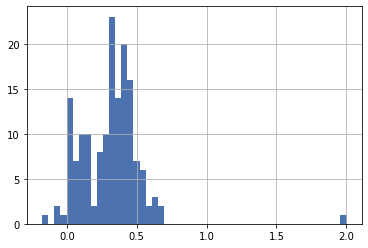

In [50]:
#analyst
df_merged.VNINDEX_beta.hist(bins=50);

In [51]:

# Ngược chiều
df_merged.sort_values(by="VNINDEX_beta").iloc[:10]

,Ticker,Adj_Close,MCAP,SectorL2,VNINDEX_beta
73,HPX,26900.0,7.114911e+12,Real Estate L2,-0.177126
193,AVC,26200.0,1.966364e+12,Utilities L2,-0.082015
144,VCP,48800.0,2.781600e+12,Construction & Materials L2,-0.060399
162,SJG,5400.0,2.427500e+12,Construction & Materials L2,-0.021144
123,PHP,10900.0,3.563864e+12,Industrial Goods & Services L2,-0.002810
106,VSF,9100.0,4.550000e+12,Food & Beverage L2,-0.002728
194,DHB,7200.0,1.959840e+12,Chemicals L2,0.000000
83,CAB,140900.0,6.445594e+12,Media L2,0.000000
62,SQC,82000.0,8.798518e+12,Basic Resources L2,0.000000
98,DTK,7400.0,5.032000e+12,Construction & Materials L2,0.000574


In [52]:

# Cùng chiều
df_merged.sort_values(by="VNINDEX_beta").iloc[-10:]

,Ticker,Adj_Close,MCAP,SectorL2,VNINDEX_beta
69,PPC,23600.0,7.566468e+12,Utilities L2,0.556348
11,TCB,22450.0,7.857814e+13,Banks L2,0.556860
79,VPI,41200.0,6.592000e+12,Real Estate L2,0.564592
25,FPT,50500.0,3.958721e+13,Technology L2,0.588487
44,KDH,24400.0,1.363488e+13,Real Estate L2,0.612597
22,MBB,19600.0,4.726396e+13,Banks L2,0.616985
0,VCB,86100.0,3.193343e+14,Banks L2,0.624690
49,REE,40400.0,1.252606e+13,Industrial Goods & Services L2,0.654652
90,E1VFVN30,14300.0,6.027450e+12,Financial Services L2,0.655265
50,BAB,17400.0,1.232790e+13,Banks L2,2.001753


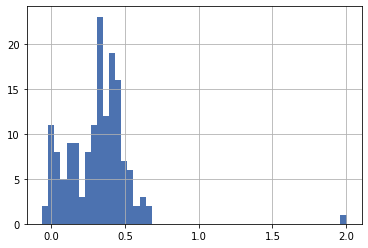

In [53]:
#code nếu cần 

# We remove left-tail outliers so that the visualisations are smoother
df_merged = df_merged[df_merged.VNINDEX_beta > df_merged.VNINDEX_beta.quantile(0.01)].sort_values(by="VNINDEX_beta")
df_merged.VNINDEX_beta.hist(bins=50);

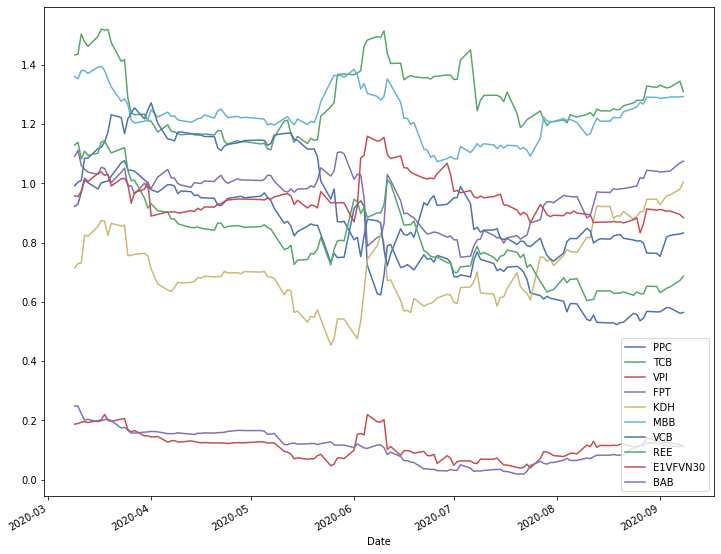

In [54]:
# Plot top 10 rolling betas
fig, ax = plt.subplots(figsize=(12,10))
top_10_tickers = df_merged.sort_values(by="VNINDEX_beta").Ticker.iloc[-10:].tolist()

res = []
period = 42 # 2months

for t in top_10_tickers:
    rolling_beta = (rets[t].rolling(period).cov(rets["VNINDEX"]) / rets["VNINDEX"].rolling(period).var()).dropna()
    res.append(rolling_beta.rename(t))
rolling_betas_top = pd.concat(res, axis=1)
rolling_betas_top.plot(ax=ax)
#k nhiều gtri
plt.show()

In [55]:
 #'Price/Earnings', 'Price/Sales', 'Price/Book'
import plotly.express as px
import numpy as np
df_merged["VN166"] = "VN166"
df_merged = df_merged.rename({"VNINDEX_beta": "VNINDEX beta"}, axis=1)
fig = px.treemap(df_merged, path=['VN166', 'SectorL2', 'Ticker'], values='MCAP',
                  color='VNINDEX beta', hover_data=['SectorL2', 'Adj_Close'], 
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df_merged['VNINDEX beta'], weights=df_merged['MCAP'])
                )
fig.update_layout(margin=dict(l=0, r=0, t=20, b=0)),
fig.show()

In [56]:
print(pd.__version__)

1.1.4


In [58]:
import chart_studio
import chart_studio.plotly as py

username = 'lf2foce'
api_key = 'mRJtBTnvg3l3fB7DSOHO'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


py.plot(fig, filename = '100beta', auto_open=True)

'https://plotly.com/~lf2foce/1/'

In [59]:
import chart_studio.tools as tls
tls.get_embed('https://plotly.com/~lf2foce/1/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~lf2foce/1.embed" height="525" width="100%"></iframe>'